In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

In [4]:
market_cap = pd.read_excel('Group_G copy.xlsx', sheet_name=1)
price_index = pd.read_excel('Group_G copy.xlsx', sheet_name=2, index_col='Date')
revenue = pd.read_excel('Group_G copy.xlsx', sheet_name=3)
emission = pd.read_excel('Group_G copy.xlsx', sheet_name=4)

In [6]:
def assets_returns(assets, period, compounded=True):
    if not compounded:
        asset_return = (assets / assets.shift(periods=period)) - 1
    elif compounded:
        diff = assets / assets.shift(periods=period)
        asset_return = np.log(diff.astype('float'))
    return asset_return

In [7]:
simple_return = assets_returns(price_index, period=1, compounded=False)

In [5]:
log_return = assets_returns(price_index, period=1, compounded=True)

/Users/victoriawong/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [9]:
def get_moment(assetReturn, moment):
    if moment == 1:
        return pd.DataFrame(assetReturn.mean())
    elif moment == 2:
        return pd.DataFrame(assetReturn.std())
    elif moment == 3:
        return pd.DataFrame(assetReturn.skew())
    elif moment == 4:
        nu = (pow(assetReturn, moment)).mean() - pow(assetReturn.mean(), moment)
        den = pow(assetReturn.std(), moment)
        res = nu / den
        return pd.DataFrame(res)

In [7]:
simple_mean = get_moment(simple_return, 1)
simple_std = get_moment(simple_return, 2)
simple_skew = get_moment(simple_return, 3)
simple_kurt = get_moment(simple_return, 4)

In [8]:
def jarque_bera(series, skewness, kurtosis):
    t = np.shape(series)[0]
    tstat = t * (pow(skewness, 2)/6 + pow((kurtosis), 2)/24)
    return tstat

In [9]:
jb_res = jarque_bera(simple_return, simple_skew, simple_kurt)

In [10]:
def jb_test(tstat, alpha, dof):
    critical_val = stats.chi2.ppf(1-alpha, df=dof)
    out = {}
    for k, v in tstat.T.items():
        if v[0] >= critical_val:

            # print(f'Reject H0: Return is not Gaussian')
            out[k] = 'Reject H0: Return is not Gaussian'
    return pd.Series(out)

In [11]:
test_res = jb_test(jb_res, 0.05, 2)

In [12]:
def get_acf(ds: pd.DataFrame, nlags=10) -> pd.DataFrame:
    out = {}
    for k in ds.keys():
        res = sm.tsa.acf(ds[k], nlags=nlags, missing='conservative')
        out[k] = res[1:]
    return pd.DataFrame(out)

In [13]:
acf = get_acf(simple_return, nlags=10)
squared_acf = get_acf(pow(simple_return, 2), nlags=10)

/Users/victoriawong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:463: RuntimeWarning: invalid value encountered in double_scalars
  xo = x - x.sum() / notmask_int.sum()
/Users/victoriawong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:518: RuntimeWarning: invalid value encountered in true_divide
  acov = np.fft.ifft(Frf * np.conjugate(Frf))[:nobs] / d[nobs - 1 :]
/Users/victoriawong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:463: RuntimeWarning: invalid value encountered in subtract
  xo = x - x.sum() / notmask_int.sum()


In [14]:
def ljung_box(acf, returns, nlag):
    t = np.shape(returns)[0]
    tstat = t*(t+2)*1/(t-nlag)*pow(acf.iloc[nlag],2)
    return tstat


lj_stat = {}
for i in range(10):
    lj_stat[i] = ljung_box(acf, simple_return, i)
lj_stat = pd.DataFrame(lj_stat).transpose()

In [10]:
# Filtered portfolio inputs
opt_simple = simple_return.dropna(thresh=145).dropna(axis=1)
opt_mean = get_moment(opt_simple, 1)
opt_vol = get_moment(opt_simple, 2)
opt_skew = get_moment(opt_simple, 3)
opt_kurt = get_moment(opt_simple, 4)


# For annualized portfolio inputs
annual_mean = pow((1+opt_mean), 252) -1
annual_vol = opt_vol * np.sqrt(252)

In [16]:
def get_weight(num_assets, size):
    weights = np.random.randn(num_assets, size)
    weights = pd.DataFrame(weights)
    for i in range(size):
        weights.iloc[:, i] = weights.iloc[:, i] / weights.iloc[:, i].sum()
    return weights


# On the rows are each asset's weight in different portfolios, each column represents a randomly generated portfolio
random_weight = get_weight(np.shape(opt_simple)[1], 1000 )

In [17]:
def portfolio_return(asset_returns, port_weight):
    if np.shape(asset_returns)[1] != np.shape(port_weight)[0]:
        port_mean = asset_returns.T.values @ port_weight.values
    else:
        port_mean = asset_returns.values @ port_weight.values
    port_mean = pd.DataFrame(port_mean).transpose()
    port_mean.index = port_weight.T.index
    port_mean.columns = ['Portfolio Mean']
    return port_mean


def vcv_matrix(asset_returns):
    return asset_returns.cov()


def portfolio_var(port_weight, vcv):
    out = {}
    for i in port_weight:
        out[i] = port_weight.iloc[:, i].values.T @ vcv.values @ port_weight.iloc[:, i].values
    out = pd.Series(out)
    out.name = 'Sigma'
    return out

In [18]:
opt_mu = portfolio_return(opt_mean, random_weight)
opt_vcv = vcv_matrix(opt_simple)
opt_sigma2 = portfolio_var(random_weight, opt_vcv)
opt_sigma = np.sqrt(opt_sigma2)
annual_opt_mu = pow((1+opt_mu), 252) -1
annual_opt_vol = opt_sigma * np.sqrt(252)

In [12]:
def efficient_frontier(mean, vcv, risk_aversion, num_port):
    """

    :param mean: All asset's expected return
    :param vcv: The variance covariance matrix
    :param risk_aversion: Investor's risk aversion
    :param num_port: Number of equally spaced return portfolios we want display on the efficient frontier
    :return: This function returns a list of objects.
        frontier: The mean variance efficient frontier with x number of MVP portfolios
        gmvp_weight: The asset allocation of the global minimum variance portfolio
        gmvp_mean: The mean of the global minimum variance portfolio
        gmvp_variance: The variance of the global minimum variance portfolio
        optimal_weight: The asset allocation of the optimal portfolio
        optimal_mean: The mean of the optimal portfolio
        optimal_variance: The variance of the optimal portfolio
    """

    e = np.ones(np.shape(mean)[0])
    vcv_inv = np.linalg.inv(vcv)
    A = mean.T @ vcv_inv @ mean
    B = mean.T @ vcv_inv @ e
    C = e.T @ vcv_inv @ e
    alpha_spec = (e.T @ vcv_inv @ mean) / risk_aversion
    alpha_min = 1-alpha_spec

    # The mean-variance efficient frontier
    mu = np.linspace(-0.1, 0.25, num_port)
    std = ((C * pow(mu, 2) - 2*B*mu + A)/(A*C-pow(B, 2))).T.reshape(-1)
    frontier = pd.DataFrame({'mu_p': mu, 'mu_std': std})

    # The global mean variance portfolio
    gmvp_weight = vcv_inv @ e / C
    gmvp_mean = gmvp_weight.T @ mean
    gmvp_variance = gmvp_weight.T @ vcv @ gmvp_weight

    # The speculative portfolio
    spec_weight = vcv_inv @ mean / (e.T @ vcv_inv @ mean)
    spec_mean = spec_weight.T @ mean
    spec_variance = spec_weight.T @ vcv @ spec_weight

    # The optimal portfolio
    optimal_weight = alpha_min * gmvp_weight.reshape(-1) + alpha_spec * spec_weight.reshape(-1)
    optimal_mean = optimal_weight.T @ mean
    optimal_variance = optimal_weight.T @ vcv @ optimal_weight

    return [frontier, gmvp_weight, gmvp_mean, gmvp_variance, optimal_weight, optimal_mean, optimal_variance]

In [31]:
r = efficient_frontier(opt_mean.values, opt_vcv.values, risk_aversion=2, num_port=100)


In [21]:
@interact()
def plot(risk_aversion=widgets.FloatSlider(min=0, max=10, step=0.1, value=1)):

    f = efficient_frontier(opt_mean.values, opt_vcv, risk_aversion=risk_aversion, num_port=100)

    ax = plt.gca()
    ax.plot(f[0]['mu_std'], f[0]['mu_p'])
    gmvp_weight = f[1]
    gmvp_retr = f[2]
    gmvp_vcv = f[3]

    optimal_variance = f[-1]
    optimal_mu = f[-2]

    ax.plot(gmvp_vcv, gmvp_retr, 'ro')
    ax.plot(optimal_variance, optimal_mu, 'bo')
    
#     d = np.linspace(0, 0.25, 101)
#     ax.plot(d, y, 'k--')
    ax.axhline(y=0,color='k', ls='-')

interactive(children=(FloatSlider(value=1.0, description='risk_aversion', max=10.0), Output()), _dom_classes=(…

In [22]:
# Efficient frontier using optimization method
def min_variance_portfolio(mean, vcv, initial_weight):
    """

    :param vcv: The variance covariance matrix
    :param initial_weight: Initial guess of asset weight allocation
    :param risk_free:
    :return: Returns a list of objects.
    1. Optimal weight allocation of assets given the covariance matrix
    2. The return of this global minimum variance portfolio
    3. The variance of this global minimum variance portfolio
    """
    obj = lambda a: a.T @ vcv @ a
    cons = {
        'type': 'eq',
        'fun': lambda a: a.T @ (np.zeros(len(a)) + 1) - 1
    }
    bnds = [[None, None] for i in range(len(initial_weight))]
    port_weight = minimize(obj, x0=initial_weight, constraints=cons, bounds=bnds)
    r = port_weight.x.reshape(1, -1)
    port_mean = r @ mean
    port_vcv = r @ vcv @ r.T
    return [port_weight, port_mean, port_vcv]

In [33]:
pweight = min_variance_portfolio(opt_mean, opt_vcv, r[1])
gmvp_weight = pweight[0]
gmvp_mean = pweight[1]
gmvp_variance = pweight[2]
gmvp_mean

,0
0,0.000407


In [34]:
def optimal_portfolio(mean, vcv, initial_weight, risk_free):
    vcv_inv = np.linalg.inv(vcv)
    ones = np.ones((np.shape(mean)[0], 1))
    
    obj = lambda a: a.T @ vcv @ a
    cons = {
        'type': 'eq',
        'fun' : lambda a: a.T @ mean + (1 - ones.T @ a) * risk_free - a.T @ mean
    }
    bnds = [(None, None) for i in range(len(initial_weight))]
    port_weight = minimize(obj, x0=initial_weight, method='SLSQP', constraints=cons, bounds=bnds)
    a_str = port_weight.x.reshape(-1, 1)
#     optimal_portfolio = port_weight.x.reshape(1, -1)
#     port_mean = optimal_portfolio @ mean
    
    excess_mu = mean - risk_free * ones
#     tan_port = (vcv_inv @ excess_mu) / (ones.T @ vcv_inv @ excess_mu)
    tan_port = a_str / (ones.T @ a_str)
    tan_mu = tan_port.T @ excess_mu + risk_free
    tan_vcv = tan_port.T @ vcv @ tan_port
#     return [port_weight.x, optimal_portfolio, port_mean, tan_port, tan_mu, tan_vcv]
    
    return tan_port, tan_mu, tan_vcv


# res = optimal_portfolio(opt_mean.values, opt_vcv, minport, 0.005)
# res[-2]


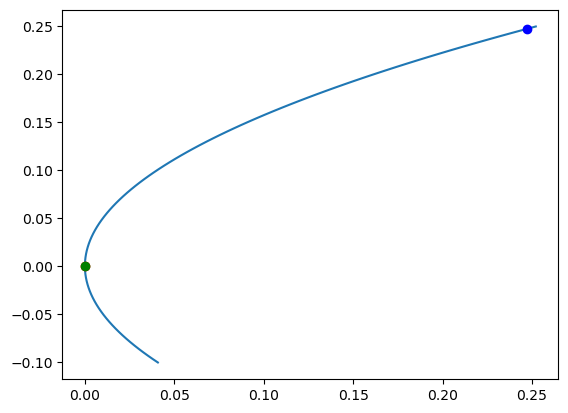

In [38]:
f = efficient_frontier(opt_mean.values, opt_vcv.values, risk_aversion=1, num_port=100)

ax = plt.gca()
ax.plot(f[0]['mu_std'], f[0]['mu_p'])
gmvp_weight = f[1]
gmvp_retr = f[2]
gmvp_vcv = f[3]

optimal_variance = f[-1]
optimal_mu = f[-2]

ax.plot(gmvp_vcv, gmvp_retr, 'ro')
ax.plot(optimal_variance, optimal_mu, 'bo')

res = optimal_portfolio(opt_mean.values, opt_vcv.values, r[1], 0.05)
ax.plot(res[-1], res[-2], 'go')
    
#     d = np.linspace(0, 0.25, 101)
#     ax.plot(d, y, 'k--')
# ax.axhline(y=0,color='g', ls='-')

In [ ]:
gmvp_vcv

In [ ]:
ax = plt.gca()
y2 = np.sqrt(f['mu_std']) # this is actually the squared root of the variance


pmus = []
pvols = []
# for i in range(len(random_weight.columns)):
#     res = ef_optimization(opt_vcv, random_weight.iloc[:, i], risk_free=False)
#
#     pmu = res.x @ opt_mean
#     pvol = res.x.T @ opt_vcv @ res.x
#     pmus.append(pmu)
#     pvols.append(pvol)
#     ax.plot(np.sqrt(pvol).T, pmu, 'ro')
#
# # ax.set_ylim(-0.01, 0.02)
# # ax.set_xlim(0, 0.05)
# ax.plot(y2, f['mu_p'])

In [ ]:
ax = plt.gca()
ax.plot(pvols, pmus, 'ro')
ax.plot(y2, f['mu_p'])
ax.set_xlim(0, 0.01)
ax.set_ylim(-0.05, 0.05)

In [ ]:
def portfolio_resampling(row_selected, num_iter, len_dummy_mu):
    """

    :param row_selected: Number of draws of raw returns we have for each sample
    :param num_iter: Number of resampled returns
    :param len_dummy_mu: Number of portfolio returns we set to optimize for portfolio volatility
    :return: The output contains multiple outputs. First, the optimal allocation given all returns, the expected return of the portfolio, the variacne of the optimal portfolios.
    """
    out = []
    optimal_weights = []
    optimal_mu = []
    optimal_vcv = []
    for i in range(num_iter):
        sam = opt_simple.sample(n=row_selected, ignore_index=True)
        mu = sam.mean()
        optimal_mu.append(mu)
        cov = sam.cov()
        optimal_vcv.append(cov)
        res = efficient_frontier(mu, cov, len_dummy_mu)
        num = np.linalg.inv(cov) @ np.ones(np.shape(cov)[0])
        den = np.ones(np.shape(cov)[0]).T @ np.linalg.inv(cov) @ np.ones(np.shape(cov)[0])
        alpha = num / den
        out.append(res['mu_std'])
        optimal_weights.append(alpha)
    df = pd.DataFrame(np.asarray(out).T, index=res['mu_p'])
    optimal_weights = pd.DataFrame(optimal_weights).T
    optimal_mu = pd.DataFrame(optimal_mu)
    return [df, optimal_weights, optimal_mu]


# def resampled_mu(row_selected, num_iter, )

In [ ]:
resampled = portfolio_resampling(300, 2000, 200)
# resampled = pd.DataFrame(np.asarray(resampled).T)
# np.shape(resampled)
# all_weights = []


# for i in range(np.shape(resampled)[0]+1):
#     resampled.iloc[:, i] = resampled.iloc[:, i] / resampled.iloc[:, i].sum()


# all_weights = pd.DataFrame(all_weights)
# all_weights.sum()
# resampled.plot(legend=False)
resampled[1].sum()

In [ ]:
final_sample = resampled.mean(axis=1)

In [ ]:
efficient_frontier(opt_mean.values, opt_vcv.values, risk_aversion=1, num_port=100)

In [ ]:
ax = plt.gca()
for i in range(len(resampled.columns)):
    ax.plot(resampled.iloc[:, i], resampled.index, 'k-', lw=0.05)
ax.plot(resampled.mean(axis=1), resampled.index, 'r-', lw=1.2)

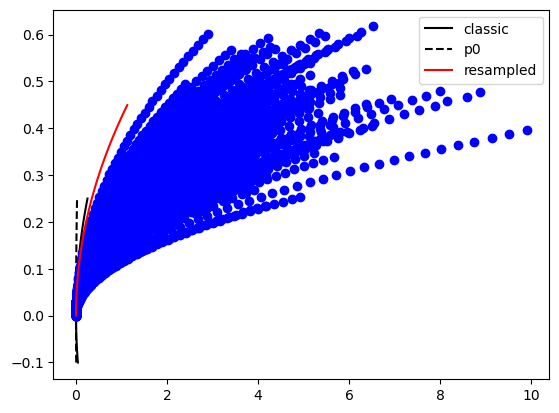

In [71]:
Q = 100
m = 51
returns = opt_simple
nb_rows = 200
risk_aversion = 2
num_port = 101

ax = plt.gca()

p0 = returns.sample(n=nb_rows, ignore_index=True)
ft, _, min_mu, min_cov, _, max_mu, max_cov = efficient_frontier(returns.mean(), returns.cov(), risk_aversion, num_port)
ax.plot(ft.mu_std, ft.mu_p, 'k-', label='classic')


ft, _, min_mu, min_cov, _, max_mu, max_cov = efficient_frontier(p0.mean(), p0.cov(), risk_aversion, num_port)
ax.plot(ft.mu_std, ft.mu_p, 'k--', label='p0')

mu_0 = p0.mean()
cov_0 = p0.cov()

opt_mus = []
opt_covs = []
a_res = [[] for i in range(m)]
for i in range(Q):
    p1 = np.random.normal(loc=p0.mean().values, scale=p0.std().values, size=p0.shape)
    mu_1 = p1.mean(axis=0).reshape(-1, 1)
    cov_1 = np.cov(p1.T)
    c = 0
    for mu in np.linspace(min_mu, max_mu, m):
        obj = lambda a: a.T @ cov_1 @ a
        cons1 = {
            'type': 'eq',
            'fun': lambda a: a.T @ (np.zeros(len(a)) + 1) - 1
        }
        cons2 = {
            'type': 'eq',
            'fun': lambda a: a.T @ mu_1 - mu
        }
        w0 = np.random.random(mu_1.shape)
        w0 /= w0.sum()
        bnds = [[None, None] for i in range(len(w0))]
        res = minimize(obj, x0=w0.reshape(-1), method='SLSQP', constraints=(cons1, cons2), bounds=bnds)
        r = res.x
        opt_mu = r.T @ mu_0
        opt_cov = r.T @ cov_0 @ r
        ax.plot(opt_cov, opt_mu, 'bo')
        opt_mus.append(opt_mu)
        opt_covs.append(opt_cov)
        a_res[c].append(r)
        c += 1
        
mu_res = []
cov_res = []
ares = []
for i in range(m):
    _a_res = np.asarray(a_res)[i].sum(axis=0)/Q
    mu_res.append(_a_res.T @ mu_0)
    cov_res.append(_a_res.T @ cov_0 @ _a_res)
    ares.append(_a_res)

ax.plot(cov_res, mu_res, 'r-', label='resampled', ms=3)
ax.legend()

        

(-0.1, 0.5)

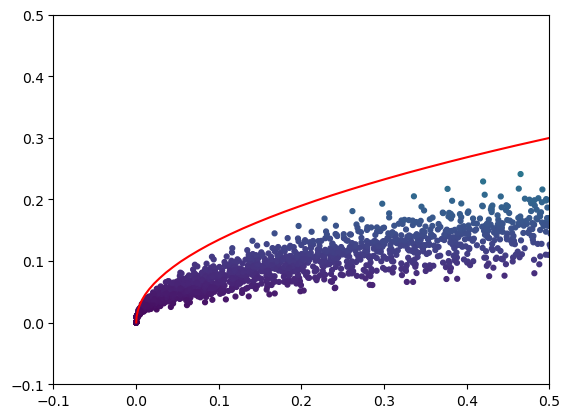

In [104]:
ax = plt.gca()

ax.plot(cov_res, mu_res, 'r-')
ax.scatter(opt_covs, opt_mus, c=np.asarray(opt_mus), s=12)
ax.set_xlim(-0.1, 0.5)
ax.set_ylim(-0.1, 0.5)
